In [1]:
import gym
import numpy as np
import collections
import sys
from tqdm import tqdm
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import math

def half_policy(obs):
    return [0.1]

def random_policy(obs):
    return [np.random.random_sample() * 4 - 2]

def stabilizing_policy(obs):
    return [- obs[2]]

def swing_up_policy(obs):
    torque = 0
    
    if (obs[0] > 0.8):
        torque = - 10 * (obs[2] + obs [1])
    
    else:
        torque = 0.08 * obs[2]
    
    torque = np.clip(torque, -2, 2)
    
    return [torque]

def run_episode(policy):
    ep_len = 1282

    env = gym.make('Pendulum-v0')
    env._max_episode_steps = ep_len
    
    observation = env.reset()

    reward_history = []
    state_action_trajectory = []

    for t in range(ep_len):
        env.render()
        
        time.sleep(0.01)
        
        action = policy(observation)
        
        state_action_trajectory.append((observation, action))
        
        observation, reward, done, info = env.step(action)
        
        reward_history.append(reward)
        
        #key = cv2.waitKey()
    
    plt.plot(reward_history)
    
    env.close()
    
    return reward_history, state_action_trajectory

def visualize_policy_action(policy, llim1, hlim1, a1name, llim2, hlim2, a2name, pnum):
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(llim1, hlim1, num = pnum)
    Y = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X, Y)

    Z = X**2 + Y**2
        
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X[i, j]
            y = Y[i, j]

            obs = [math.cos(x), math.sin(x), y]

            t = policy(obs)[0]
            
            #print(t)
            
            #t = np.clip(t, -2, 2)
            
            Z[i, j] = t
    
    # Plot a basic wireframe.
    ax.view_init(30, 60)
    ax.set_zlim(-2.0, 2.0)
    ax.plot_wireframe(X, Y, Z)#, rstride=10, cstride=10)

    ax.set_xlabel(a1name, fontsize=20, rotation=150)
    ax.set_ylabel(a2name)
    ax.set_zlabel(r'torque', fontsize=30, rotation=60)
    
    plt.show()

#policies = [half_policy, random_policy, stabilizing_policy, destabilizing_policy, swing_up_policy]
#policies = [half_policy, nn_policy, swing_up_policy]

#for trajectory plotting
#ax.scatter(xs,ys,zs)

#for policy in policies:
#    visualize_policy_action(policy, -math.pi, math.pi, "angle", -8.0, 8.0, "angular velocity", 16)

In [2]:
#_, sat = run_episode(swing_up_policy)

print(sat)

NameError: name 'sat' is not defined

Let us try to train a NN to reproduce the actions of an agent(?)
At least train NN to perform (x_k, u_k) -> x_{k+1}

function inputs:
- policy
- NN specs
- metric(?)

-------------

Custom env to draw predicted state on top of the actual state

Video with the visualization of the NN training

In [2]:
class PolicyNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden):
        super().__init__()
        
        #self.criterion = nn.L1Loss()
        self.criterion = nn.MSELoss()
                
        self.fc1   = nn.Linear(dim_in, dim_hidden)
        self.relu1 = nn.LeakyReLU()
        
        self.fc2   = nn.Linear(dim_hidden, dim_hidden)
        self.relu2 = nn.LeakyReLU()
        self.fc3   = nn.Linear(dim_hidden, dim_hidden)
        self.relu3 = nn.LeakyReLU()
        
        self.fc4   = nn.Linear(dim_hidden, dim_out)

        self.double()
        
        self.loss = 0
        
    def forward(self, x):
        x = x.double()

        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        
        return x
    
    def zero_loss(self):
        self.loss = 0

    def model_out(self, inp):
        to_torch = torch.tensor(inp)

        return self.forward(to_torch)

    def output_loss(self, inp, true_pred):
        out = self.model_out(inp)
        self.loss = self.criterion(out, torch.tensor(true_pred).double())
        
        return self.loss.detach().numpy(), out

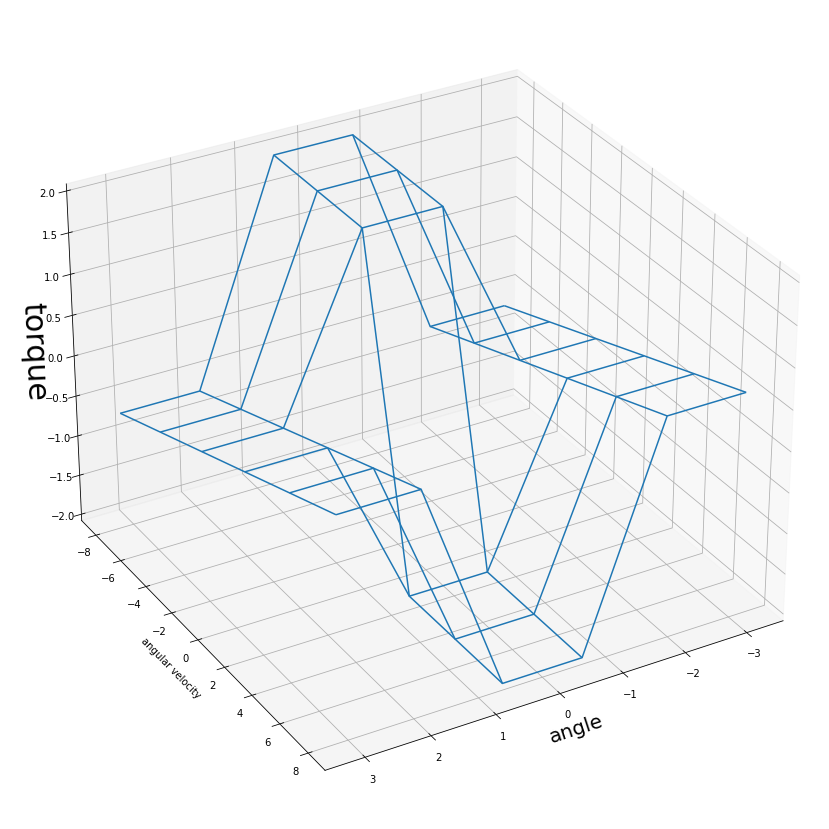

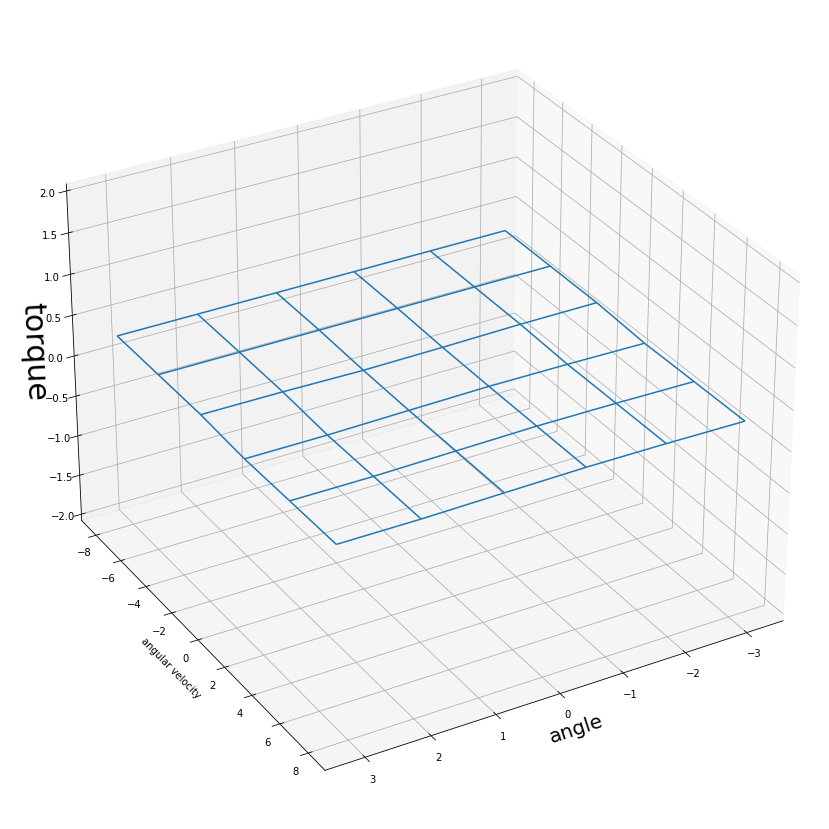

loss 56.12406762387882


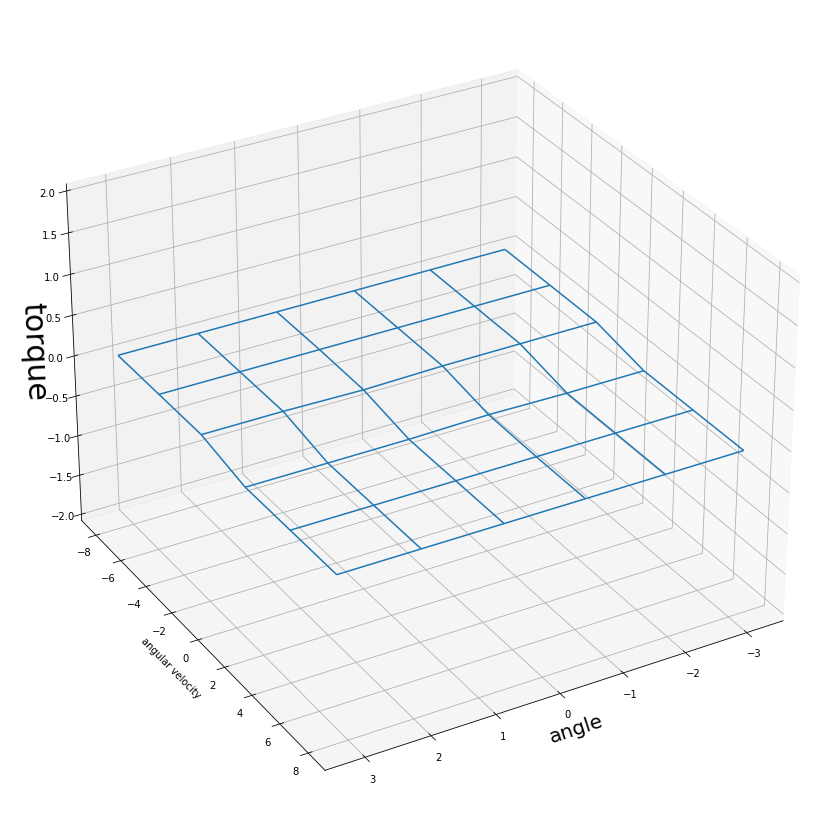

loss 50.91507714795906


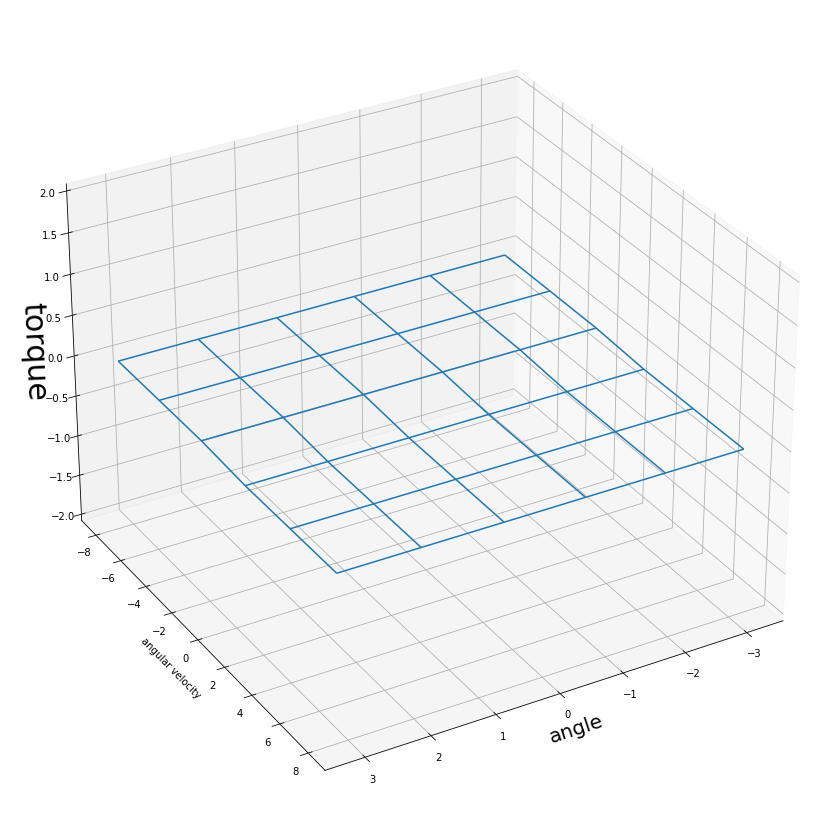

loss 52.0041795820576


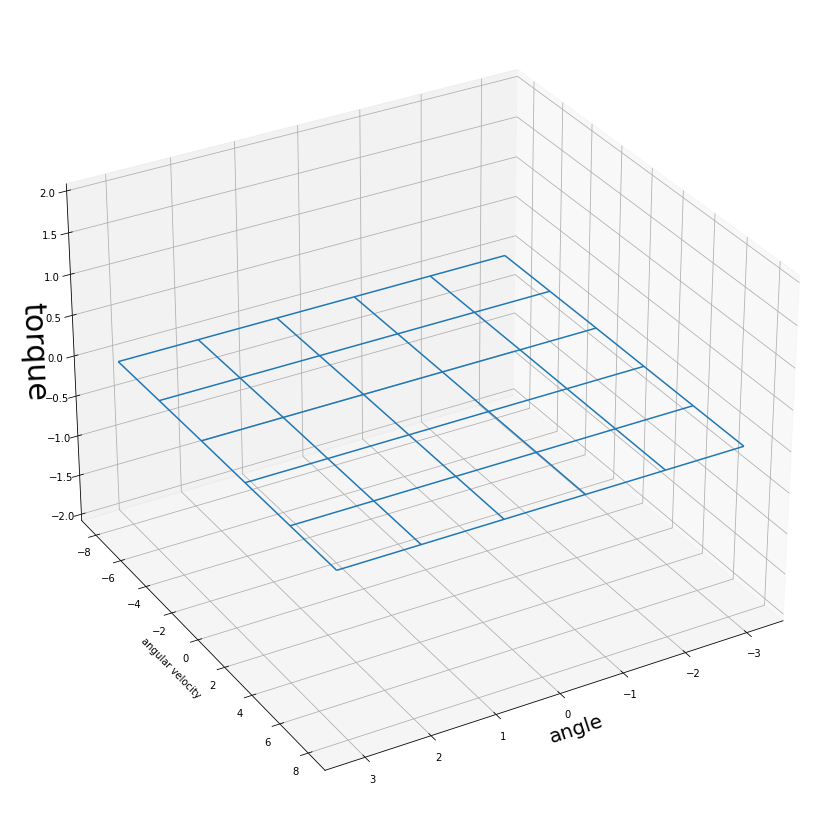

loss 52.50753272618405


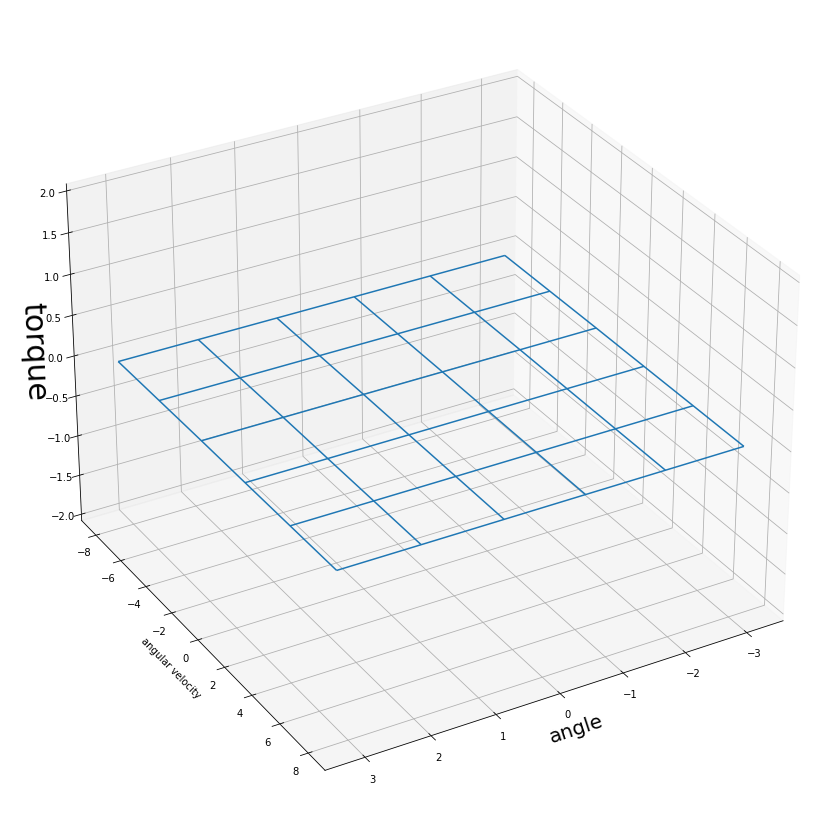

loss 52.49312136345937


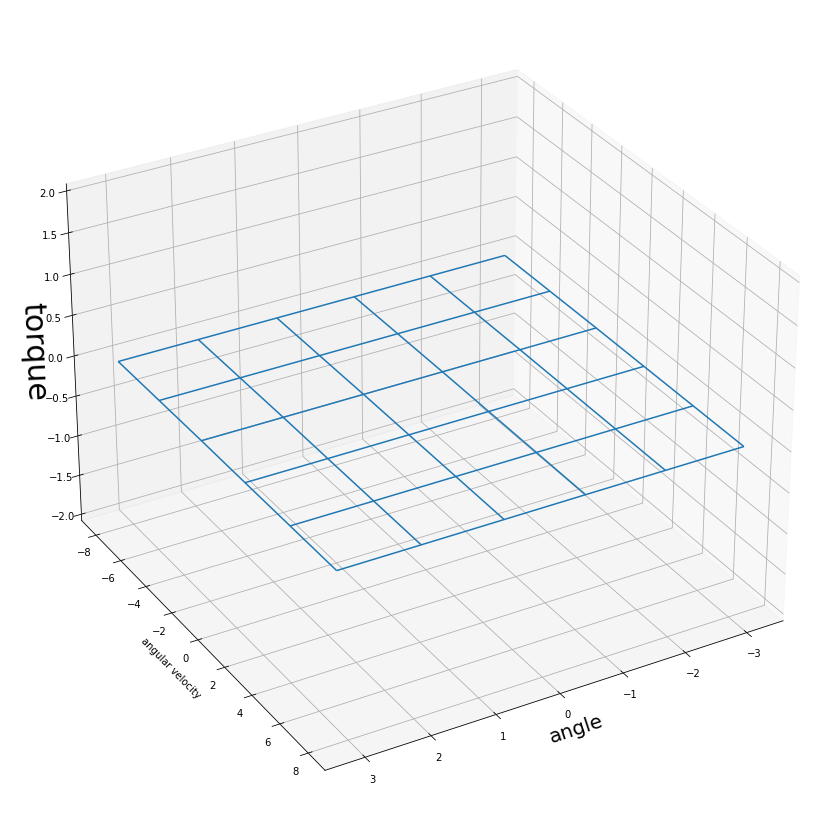

loss 52.47587121487963


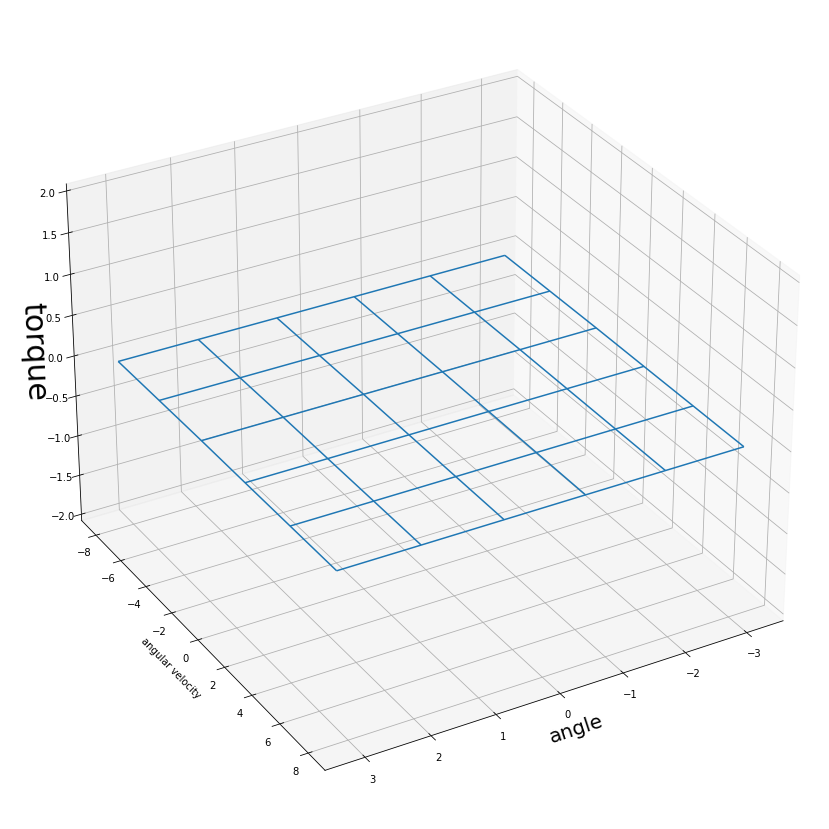

loss 52.45429166983302


In [5]:
model = PolicyNN(3, 1, 4)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

def nn_policy(obs):
    return [model.model_out(obs).detach().numpy()]

def learn_policy(policy):    
    epochs_num = 1000

    llim1, hlim1, llim2, hlim2 = -math.pi, math.pi, -8.0, 8.0

    pnum = 6
    
    visualize_policy_action(policy, llim1, hlim1, "angle", llim2, hlim2, "angular velocity", pnum)
    
    for _ in range(epochs_num):
        X = np.linspace(llim1, hlim1, num = pnum)
        Y = np.linspace(llim2, hlim2, num = pnum)

        X, Y = np.meshgrid(X, Y)

        Z = X**2 + Y**2

        acc_loss = 0
        
        #optimizer.zero_grad()
        
        for i in range(len(X)):
            for j in range(len(X[0])):
                optimizer.zero_grad()
                
                x = X[i, j]
                y = Y[i, j]

                obs = [math.cos(x), math.sin(x), y]

                policy_pred = policy(obs)
                
                loss, output = model.output_loss(obs, policy_pred)

                acc_loss += loss

                model.loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
                optimizer.step()
                #model.zero_loss()

        if (_ % 150 == 0):
            visualize_policy_action(nn_policy, llim1, hlim1, "angle", llim2, hlim2, "angular velocity", pnum)
            #for param in model.parameters():
            #    print(param.data)
            
            print("loss", acc_loss)

#learn_policy(stabilizing_policy)
learn_policy(swing_up_policy)